## Timm for Deep Learning Computer Vision Tasks

`Pytorch Image Models (timm)` is a deep-learning library that contains state-of-the-art (SOTA) models, data loaders and other tools for computer vision tasks.

Install timm on your virtual environment via pip: `pip install timm`

In [1]:
import timm

We can list all available models in timm using the `list_models()` command. At the same time, we can filter this list by specifying a model name and/or toggling the `pretrained` argument as shown below.

Note: `pprint` is just a fancy `print` function that outputs results _not_ in a single line. It's very helpful when inspecting large data to avoid clutter.

In [2]:
from pprint import pprint

#pprint(timm.list_models('*'))                     # all available models
pprint(timm.list_models('deit*', pretrained=True)) # deit pretrained models

['deit_base_distilled_patch16_224',
 'deit_base_distilled_patch16_384',
 'deit_base_patch16_224',
 'deit_base_patch16_384',
 'deit_small_distilled_patch16_224',
 'deit_small_patch16_224',
 'deit_tiny_distilled_patch16_224',
 'deit_tiny_patch16_224']


With a model in mind, we load this model by calling the `create_model` function. In this experiment, we'll use Facebook's DEIT distilled and tiny model version.

For more info about DEIT, please read their <a href="https://arxiv.org/pdf/2012.12877.pdf">arxiv paper</a>.

In [3]:
model = timm.create_model('deit_tiny_distilled_patch16_224', pretrained=True)

### Using timm for inferencing on pre-trained models

We will use this loaded pretrained model to do some cool classifications on random image/s. You may replace the image below with other images you  may have. 

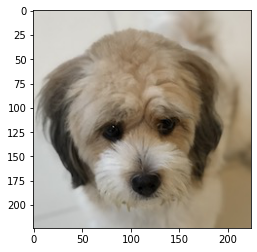

In [4]:
from PIL import Image
import matplotlib.pyplot as plt

image = Image.open('data/aki_dog.jpg')
plt.imshow(image)
plt.show()

Now, this image is most likely an M x N x 3 data, with (M, N) being the image size and 3 as the `num_channel` given it's a colored image. You may verify the image shape by calling numpy.

In [5]:
import numpy as np
np.array(image).shape

(224, 224, 3)

Now, DEIT actually accepts 224-by-224 image sizes. This is indicated by their model name `deit_tiny_patch16_224`, with `16` being the patch size and `224` being the image size.

In any case, we'll create a general data transform function below. This not only resize images to the model's accepted shape, but also transforms our numpy data to tensors.

Please read more about <a href="https://pytorch.org/vision/stable/transforms.html">torchvision transforms</a> for other image transformation functions.

In [6]:
from torchvision import transforms

transform = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor()
])

input = transform(image).unsqueeze(0)
output = model(input)

Given the predicted output by the model, we convert them into probabilities using `softmax`. At the same time, we use the `topk` function to output the top k results of the model.

In [7]:
import torch
k = 3 # We only output top k=3 results

scores = torch.nn.functional.softmax(output[1], dim=-1)[0]
top_scores, top_labels = torch.topk(scores, k=k, dim=-1)

Given the topk scores and labels, we cross-inspect this with ImageNet's corresponding label names.

In [8]:
with open('imagenet_classes.txt', 'r') as file:
    imagenet_labels = [label.strip() for label in file.readlines()]
    
for i in range(k):
    label_name = imagenet_labels[top_labels[i]]
    print("Top {} Label {}: {}".format(i, top_labels[i], label_name))

Top 0 Label 200: Tibetan terrier
Top 1 Label 204: Lhasa
Top 2 Label 155: Shih-Tzu


Of course, timm may not only be used to load existing models and do inferencing. It can also be used to customize said models by adding additional arguments in the `create_model` function, and do further training.

### Using timm for feature extraction

Last task we will explore using timm is feature extraction. Generally, neural network (NN) models aren't used only to output image classes or segmentation. They are, first and foremost, good feature extractors as well because of their flexibility (unlike rule-based methods for example). Hence, as you will read more papers later, you will sometimes encounter works that use other NN models simply as feature extractors for a more specific downstream task.

In this section, we therefore explore feature extraction using timm.

In [9]:
# pprint(timm.list_models('resnet*', pretrained=True))
model = timm.create_model('resnet18', pretrained=True, features_only=True)
model.feature_info.module_name()

['act1', 'layer1', 'layer2', 'layer3', 'layer4']

By passing the `features_only` argument in the `create_model` function, we effectively made our `resnet18` model as a feature extractor-only model that extracts features from certain layers.

In [10]:
outputs = model(input)
len(outputs)

5

We visualize our output using `matplotlib`.

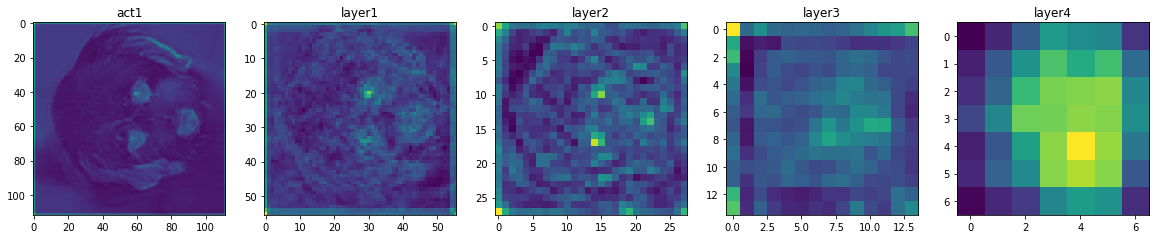

In [11]:
fig = plt.figure(figsize=(20,20))
rows, cols = 1, 5

for i in range(len(outputs)):
    feats = outputs[i][0].transpose(0,2).sum(-1).detach().numpy()
    
    fig.add_subplot(rows, cols, i+1)
    plt.imshow(feats)
    plt.title(model.feature_info.module_name()[i])

For more info about timm, please read the <a href="https://fastai.github.io/timmdocs/">timm documentary</a> or check out Ross Wightman's <a href="https://github.com/rwightman/pytorch-image-models">timm github</a>.